## Vision Transformer (ViT)

### Trabajo Práctico N° 1


## Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math
import time
import pandas as pd
import numpy as np
from contextlib import contextmanager

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

# Clase para el embedding posicional aprendido que cubre el punto 2    
class PositionalEncodingLearned(nn.Module):
    """
    Implementación de un embedding posicional aprendido para modelos Transformer.
    A diferencia del encoding sinusoidal fijo, estos parámetros se aprenden durante el entrenamiento.
    """
    def __init__(self, num_patches, embed_dim, dropout=0.1):
        super(PositionalEncodingLearned, self).__init__()
        # Crear parámetros aprendibles para las posiciones
        # Inicialización con distribución normal con pequeña desviación estándar
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        
        # Inicialización de los parámetros
        self._reset_parameters()
        
        # Dropout opcional después de sumar los embeddings posicionales
        self.dropout = nn.Dropout(p=dropout)
    
    def _reset_parameters(self):
        """Inicializa los parámetros de embedding posicional"""
        nn.init.normal_(self.pos_embedding, std=0.02)
    
    def forward(self, x):
        """
        Añade embeddings posicionales aprendidos a los embeddings de entrada.
        
        Args:
            x: Tensor de embeddings de entrada [batch_size, num_patches, embed_dim]
        
        Returns:
            x: Tensor con embeddings posicionales añadidos [batch_size, num_patches, embed_dim]
        """
        x = x + self.pos_embedding
        return self.dropout(x)

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()

In [2]:
# Función para seleccionar el tipo de encoding posicional
def create_positional_encoding(encoding_type, num_patches, embed_dim, dropout=0.1):
    """
    Crea un módulo de encoding posicional según el tipo especificado.
    
    Args:
        encoding_type: Tipo de encoding ('sinusoidal' o 'learned')
        num_patches: Número de parches
        embed_dim: Dimensión del embedding
        dropout: Tasa de dropout (solo para 'learned')
    
    Returns:
        Un módulo de encoding posicional
    """
    if encoding_type.lower() == 'sinusoidal':
        return PositionalEncoding(num_patches, embed_dim)
    elif encoding_type.lower() == 'learned':
        return PositionalEncodingLearned(num_patches, embed_dim, dropout)
    else:
        raise ValueError(f"Tipo de encoding posicional no reconocido: {encoding_type}. "
                        f"Debe ser 'sinusoidal' o 'learned'.")


# Uso Context manager para medir el tiempo de ejecución de un bloque de código
@contextmanager
def temporizador(label=""): 
    inicio = time.time()
    try:
        yield
    finally:
        fin = time.time()
        return fin - inicio


def ejecutar_vit_parametrizado(img_path, img_size, patch_size, embed_dim, 
                              pos_encoding_type='sinusoidal', visualizar=False):
    tiempos = {}
    
    # Preprocesamiento
    inicio = time.time()
    config = ConfigPreprocess(img_path, img_size, patch_size)
    fin = time.time()
    tiempos['preprocesamiento'] = fin - inicio
    
    # Extracción de parches
    inicio = time.time()
    patches = config.extract_patches(config.test_img.squeeze(0))
    if visualizar:
        Visualization.visualize_patches(patches)
    fin = time.time()
    tiempos['extraccion_parches'] = fin - inicio
    
    # Generación de embeddings
    inicio = time.time()
    embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
    patches = embedded_patches(config.test_img)    
    fin = time.time()
    tiempos['generacion_embeddings'] = fin - inicio
    
    # Codificación posicional
    inicio = time.time()
    num_patches = (img_size // patch_size) ** 2
    positional_encoding = create_positional_encoding(pos_encoding_type, num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)
    fin = time.time()
    tiempos['codificacion_posicional'] = fin - inicio
    
    # Guardamos el tipo de codificación posicional
    tiempos['pos_encoding_type'] = pos_encoding_type
    
    # Visualizamos opcionalmente
    if visualizar:
        inicio = time.time()
        Visualization.visualize_positional_encoding(pos_embeddings)
        Visualization.visualize_single_patch_encoding(pos_embeddings, 0)  # Patch_idx igual a 0
        fin = time.time()
        tiempos['visualizacion'] = fin - inicio
    
    # Agregamos los datos adicionales para el análisis posterior
    tiempos['patch_size'] = patch_size
    tiempos['embed_dim'] = embed_dim
    tiempos['num_patches'] = num_patches
    tiempos["total"] = sum(
        v
        for k, v in tiempos.items()
        if isinstance(v, (int, float))
        and k not in ["patch_size", "embed_dim", "num_patches", "pos_encoding_type"]
    )
    
    # Estimación de memoria (MB)
    memoria_patches = (num_patches * 3 * patch_size * patch_size * 4) / (1024 * 1024)  # Parches originales
    memoria_embeddings = (num_patches * embed_dim * 4) / (1024 * 1024)  # Embeddings
    # Para el encoding posicional aprendido, sumamos la memoria adicional requerida por los parámetros
    memoria_pos_encoding = 0
    if pos_encoding_type.lower() == 'learned':
        memoria_pos_encoding = (num_patches * embed_dim * 4) / (1024 * 1024)  # Parámetros aprendidos
    
    tiempos['memoria_patches_mb'] = memoria_patches
    tiempos['memoria_embeddings_mb'] = memoria_embeddings
    tiempos['memoria_pos_encoding_mb'] = memoria_pos_encoding
    tiempos['memoria_total_mb'] = memoria_patches + memoria_embeddings + memoria_pos_encoding
    
    return tiempos, pos_embeddings



In [3]:
# Función para comparar visualmente ambos tipos de encoding posicional
def comparar_posicional_encodings(img_path, img_size, patch_size, embed_dim):
    """
    Compara visualmente los encodings posicionales sinusoidales y aprendidos.
    """
    print(f"Comparando encodings posicionales para patch_size={patch_size}, embed_dim={embed_dim}")
    
    # Generar patches y embeddings (parte común)
    config = ConfigPreprocess(img_path, img_size, patch_size)
    embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
    patches = embedded_patches(config.test_img)
    
    # Número de parches
    num_patches = (img_size // patch_size) ** 2
    
    # Generar embeddings posicionales sinusoidales
    sinusoidal_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
    sinusoidal_embeddings = sinusoidal_encoding(patches)
    
    # Generar embeddings posicionales aprendidos
    learned_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    learned_embeddings = learned_encoding(patches)
    
    # Comparar visualmente
    plt.figure(figsize=(20, 10))
    
    # Gráfico para encoding sinusoidal
    plt.subplot(2, 1, 1)
    plt.title('Encoding Posicional Sinusoidal (fijo)', fontsize=16, weight='bold')
    for i in range(min(8, embed_dim)):  # Mostramos hasta 8 dimensiones para claridad
        plt.plot(sinusoidal_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i+1}')
    plt.xlabel('Índice del Parche', fontsize=14)
    plt.ylabel('Valor del Encoding', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Gráfico para encoding aprendido
    plt.subplot(2, 1, 2)
    plt.title('Encoding Posicional Aprendido (inicialización)', fontsize=16, weight='bold')
    for i in range(min(8, embed_dim)):  # Mostramos hasta 8 dimensiones para claridad
        plt.plot(learned_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i+1}')
    plt.xlabel('Índice del Parche', fontsize=14)
    plt.ylabel('Valor del Encoding', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"comparacion_encodings_p{patch_size}_e{embed_dim}.png")
    plt.show()
    
    print(f"Comparación guardada en 'comparacion_encodings_p{patch_size}_e{embed_dim}.png'")
    
    return sinusoidal_embeddings, learned_embeddings


# Código para probar y comparar ambos tipos de encoding
def probar_tipos_encoding():
    img_path = "raccoon.jpg"
    img_size = 900
    patch_size = 60  # Un tamaño intermedio para la visualización
    embed_dim = 16   # Dimensión para visualizar claramente
    
    # Comparar ambos tipos de encoding
    sinusoidal_embeddings, learned_embeddings = comparar_posicional_encodings(
        img_path, img_size, patch_size, embed_dim
    )
    
    # Ejecutar el modelo con ambos tipos de encoding y medir tiempos
    print("\nComparando tiempos de ejecución:")
    resultado_sinusoidal, pos = ejecutar_vit_parametrizado(
        img_path, img_size, patch_size, embed_dim, pos_encoding_type='sinusoidal', visualizar=True
    )
    
    resultado_learned, _ = ejecutar_vit_parametrizado(
        img_path, img_size, patch_size, embed_dim, pos_encoding_type='learned', visualizar=True
    )
    
    # Mostrar comparación de tiempos
    print(f"\nTiempo total (Sinusoidal): {resultado_sinusoidal['total']:.4f}s")
    print(f"Tiempo total (Aprendido): {resultado_learned['total']:.4f}s")
    print(f"Diferencia: {resultado_learned['total'] - resultado_sinusoidal['total']:.4f}s")
    
    # Analizar la estructura de los embeddings
    plt.figure(figsize=(15, 10))
    
    # Mostrar la distribución de valores para cada tipo
    plt.subplot(2, 2, 1)
    plt.hist(sinusoidal_embeddings.detach().cpu().numpy().flatten(), bins=50, alpha=0.7)
    plt.title('Distribución de Valores (Sinusoidal)', fontsize=14)
    plt.xlabel('Valor', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(True)


    plt.subplot(2, 2, 2)
    plt.hist(learned_embeddings.detach().cpu().numpy().flatten(), bins=50, alpha=0.7)
    plt.title('Distribución de Valores (Aprendido)', fontsize=14)
    plt.xlabel('Valor', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(True)
    
    # Mostrar la estructura 2D (visualizar las primeras 2 dimensiones para todos los parches)
    plt.subplot(2, 2, 3)
    plt.scatter(
        sinusoidal_embeddings[0, :, 0].detach().cpu().numpy(),
        sinusoidal_embeddings[0, :, 1].detach().cpu().numpy(),
        alpha=0.7
    )
    plt.title('Estructura 2D (Sinusoidal)', fontsize=14)
    plt.xlabel('Dimensión 1', fontsize=12)
    plt.ylabel('Dimensión 2', fontsize=12)
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.scatter(
        learned_embeddings[0, :, 0].detach().cpu().numpy(),
        learned_embeddings[0, :, 1].detach().cpu().numpy(),
        alpha=0.7
    )
    plt.title('Estructura 2D (Aprendido)', fontsize=14)
    plt.xlabel('Dimensión 1', fontsize=12)
    plt.ylabel('Dimensión 2', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("analisis_encodings.png")
    plt.show()
    
    print("\nAnálisis de encodings guardado en 'analisis_encodings.png'")

- **Punto 1. Modificando los parámetros.**

En este punto se usará la implementación de position encoding sinusoidal, con diferentes tamaños de parches y dimensiones de embdeddings.

In [4]:
# Parámetros
img_path = "raccoon.jpg"
img_size = 900 
#patch_sizes = [8, 16, 36, 80, 200] # Defino diferentes tamaño de parche a probar
patch_sizes = [16, 36, 60, 90, 180, 300] 
#embed_dims = [8, 16, 32, 64, 128, 256] # Defino diferentes dimensiones de embeddings
embed_dims = [8, 16, 32, 64, 128, 256] 
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

resultados = []

In [5]:
texto_analisis = "Inicio del análisis de parámetros"
print(texto_analisis)
print("-" * len(texto_analisis))

Inicio del análisis de parámetros
---------------------------------


In [6]:
alto

NameError: name 'alto' is not defined

In [ ]:
for patch_size in patch_sizes:
    for embed_dim in embed_dims:
        # Verificamos que el tamaño del parche sea válido (divisor de img_size)
        if img_size % patch_size != 0:
            print(f"Saltando patch_size={patch_size} por que no es divisor de img_size={img_size}")
            continue

        print(f"Evaluando con patch_size={patch_size}, embed_dim={embed_dim}")
        try:
            # resultado = ejecutar_vit_parametrizado(img_path, img_size, patch_size, embed_dim, visualizar=False) # Visualizar activo o no activo graficas
            resultado, _ = ejecutar_vit_parametrizado(
                img_path,
                img_size,
                patch_size,
                embed_dim,
                pos_encoding_type="sinusoidal",
                visualizar=True,
            )
            resultados.append(resultado)
            num_patches = resultado['num_patches']
            print(f" Tiempo total: {resultado['total']:.4f}s, Num. parches: {num_patches}, Mem. aprox, {resultado['memoria_total_mb']:.2f} MB")
        except Exception as e:
            print(f"Error con patch_size={patch_size}, embed_dim={embed_dim}: {str(e)}")
        print("-"*30)

In [ ]:
# Convertimos a DataFrame para un mejor análisis
df_resultados = pd.DataFrame(resultados)
print(f"\nResultados completos:")
print(df_resultados[['patch_size', 'embed_dim', 'num_patches', 'total', 'memoria_total_mb']])

# Guardamos los resultados en un archivo 
df_resultados.to_csv('tp1_resultados.csv', index=False)
print("\nResultados guardados en 'tp1_resultados.csv'")


In [ ]:
# Visualización de resultados
plt.figure(figsize=(20, 16))

# Gráfico 1: Tiempo total vs Tamaño de parche por dimensión de embedding
plt.subplot(2, 2, 1)
for embedd_dim in embed_dims:
    datos = df_resultados[df_resultados['embed_dim'] == embed_dim]
    if not datos.empty:
        plt.plot(datos['patch_size'], datos['total'], 'o-', label=f'Embed Dim: {embed_dim}')

plt.xlabel('Tamaño de Parche', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Tamaño del Parche', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 2: Tiempo total vs Número de parches por dimensión de embedding
plt.subplot(2, 2, 2)
for embed_dim in embed_dims:
    datos = df_resultados[df_resultados['embed_dim'] == embed_dim]
    if not datos.empty:
        plt.plot(datos['num_patches'], datos['total'], 'o-', label=f'Embed Dim: {embed_dim}')
plt.xlabel('Número de Parches', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Número de Parches', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 3: Tiempo total vs Dimensión de embedding por tamaño de parche
plt.subplot(2, 2, 3)
for patch_size in patch_sizes:
    datos = df_resultados[df_resultados['patch_size'] == patch_size]
    if not datos.empty:
        plt.plot(datos['embed_dim'], datos['total'], 'o-', label=f'Patch Size: {patch_size}')
plt.xlabel('Dimensión del Embedding', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Dimensión del Embedding', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 4: Memoria vs Tiempo (scatter plot con colores por dimensión)
plt.subplot(2, 2, 4)
scatter = plt.scatter(df_resultados['memoria_total_mb'], df_resultados['total'], 
                     c=df_resultados['num_patches'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Número de Parches')
plt.xlabel('Memoria Estimada (MB)', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo vs Memoria', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.savefig("tp1_analisis_parametros.png")
plt.show()

print("\nGráficos guardados en 'tp1_analisis_parametros.png'")

In [ ]:
# Análisis adicional: Desglose de tiempo por etapa
plt.figure(figsize=(15, 10))

# Seleccionamos algunas configuraciones representativas para mostrar desglose de tiempo
configs_representativas = df_resultados.iloc[[0, len(df_resultados)//4, len(df_resultados)//2, 3*len(df_resultados)//4, -1]]

labels = [f"P{row['patch_size']}_E{row['embed_dim']}" for _, row in configs_representativas.iterrows()]
preprocesamiento = configs_representativas['preprocesamiento']
extraccion = configs_representativas['extraccion_parches']
embeddings = configs_representativas['generacion_embeddings']
posicional = configs_representativas['codificacion_posicional']

x = np.arange(len(labels))
width = 0.2

plt.bar(x - 1.5*width, preprocesamiento, width, label='Preprocesamiento')
plt.bar(x - 0.5*width, extraccion, width, label='Extracción de Parches')
plt.bar(x + 0.5*width, embeddings, width, label='Generación de Embeddings')
plt.bar(x + 1.5*width, posicional, width, label='Codificación Posicional')

plt.xlabel('Configuración (Patch_Embed)', fontsize=12)
plt.ylabel('Tiempo (s)', fontsize=12)
plt.title('Desglose de Tiempo por Etapa del Proceso', fontsize=14)
plt.xticks(x, labels)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig("tp1_desglose_tiempos.png")
plt.show()

print("\nDesglose de tiempos guardado en 'tp1_desglose_tiempos.png'")


- **Punro 2. Implementar embedding posicional aprendido 1D:**

En este punto se usará la clase PositionalEncodingLearned para comparar los dos tipos de positional encodingf.

Comparando encodings posicionales para patch_size=60, embed_dim=16
Dispositivo utilizado: cuda


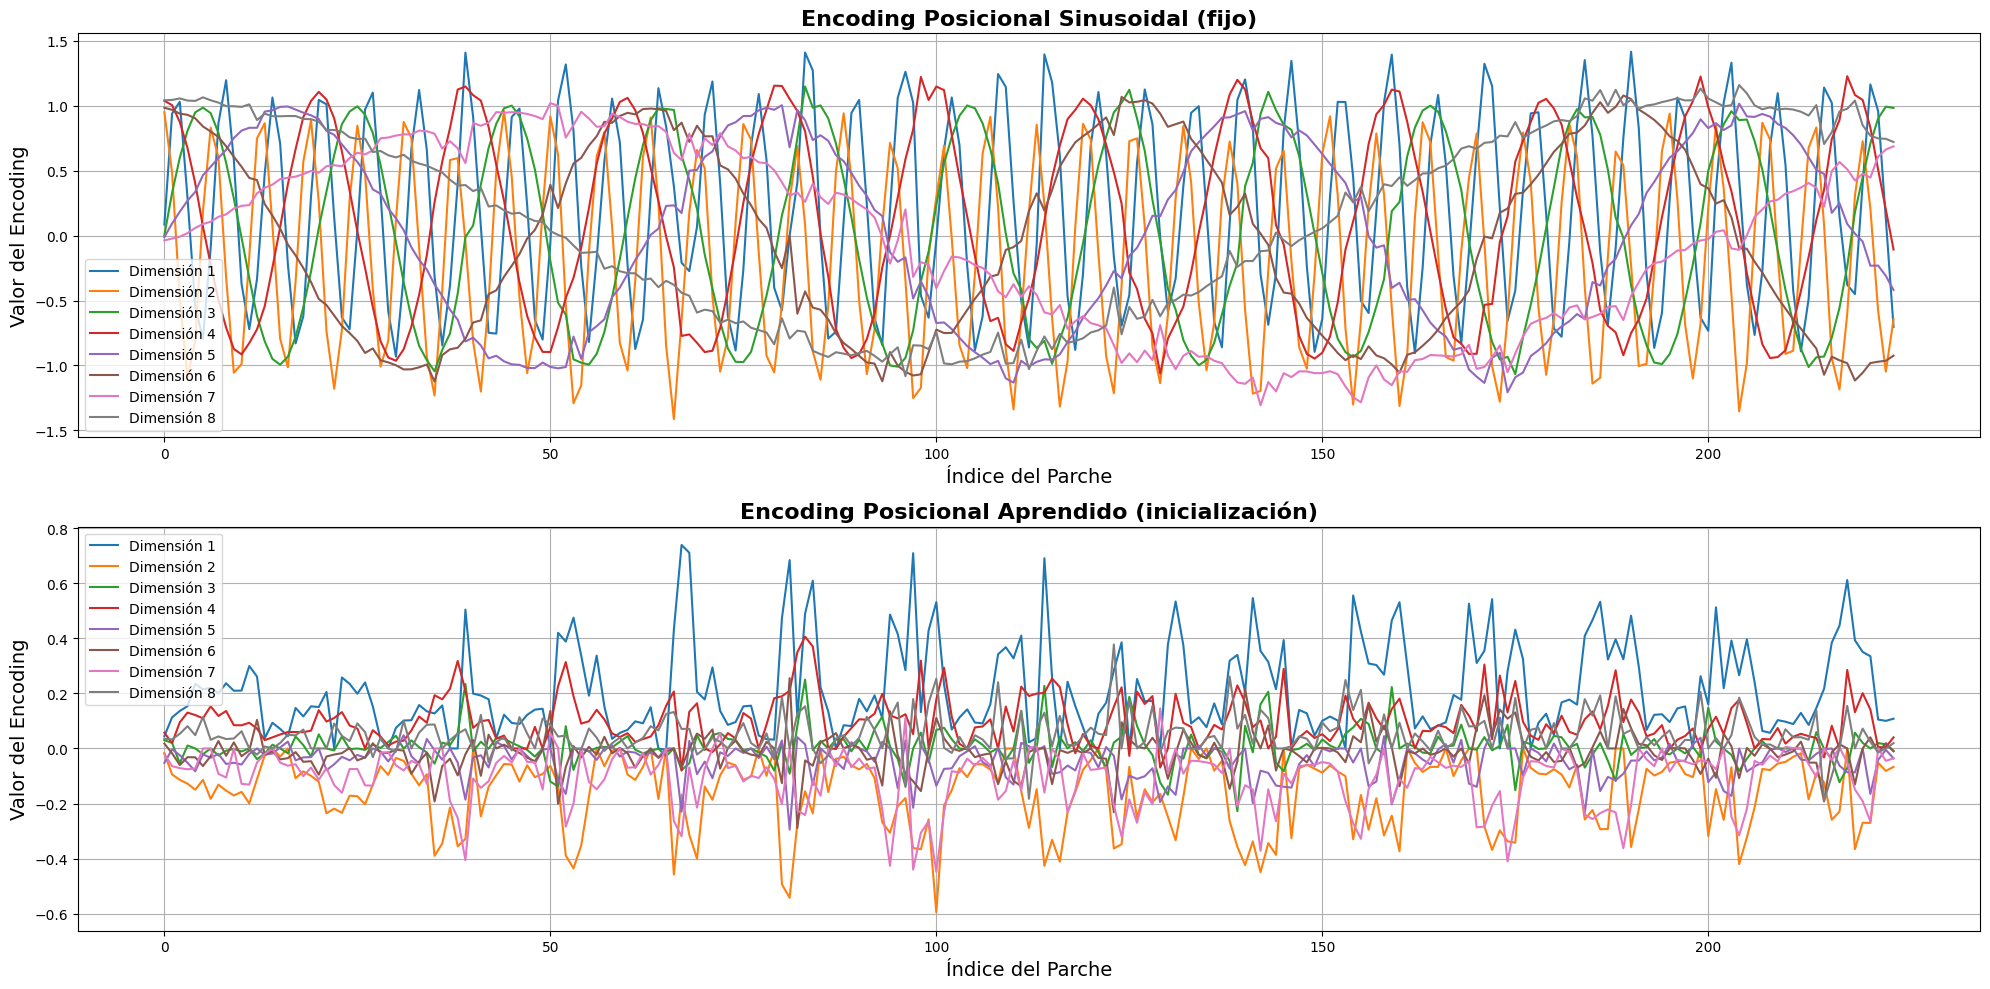

Comparación guardada en 'comparacion_encodings_p60_e16.png'

Comparando tiempos de ejecución:
Dispositivo utilizado: cuda


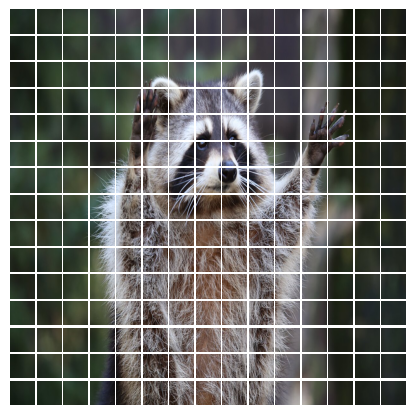

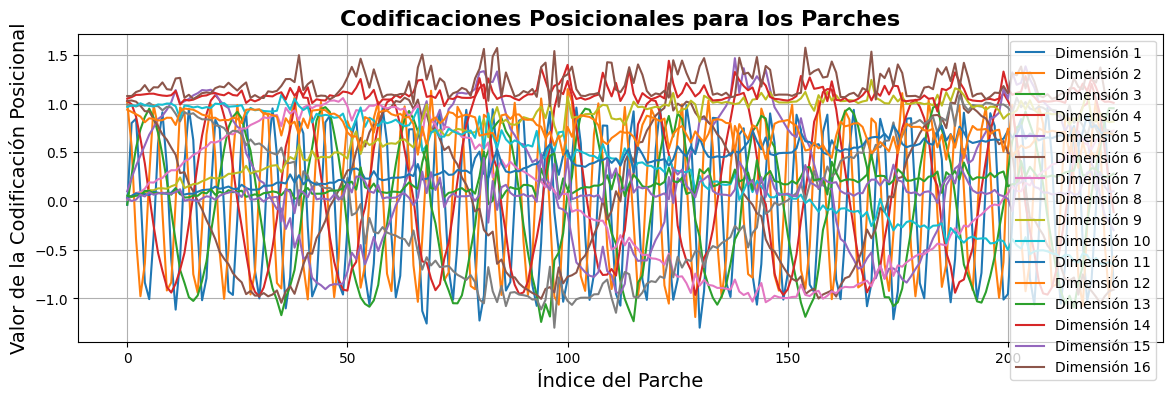

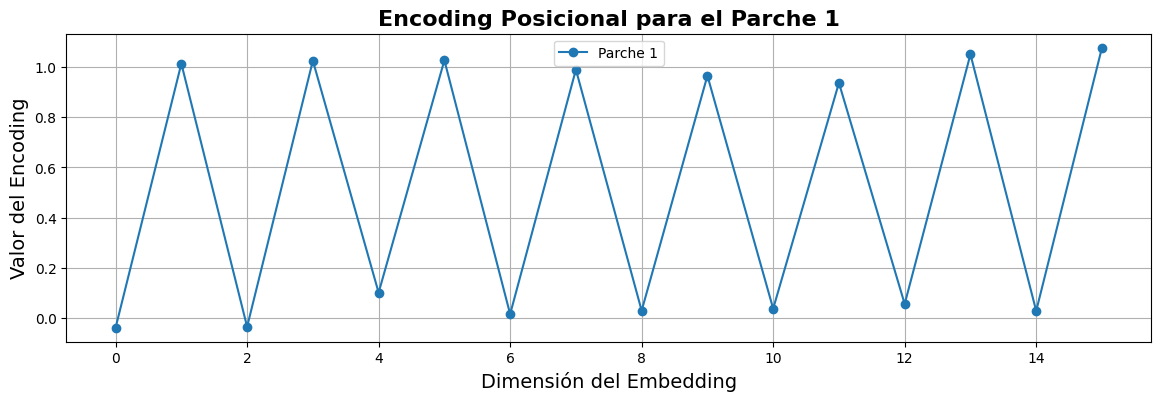

Dispositivo utilizado: cuda


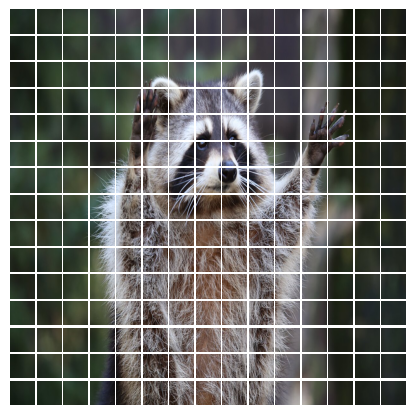

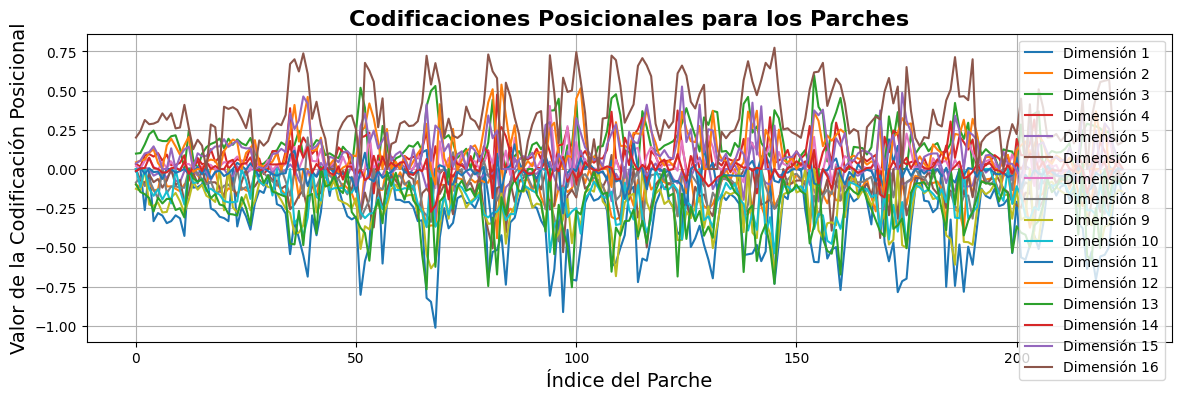

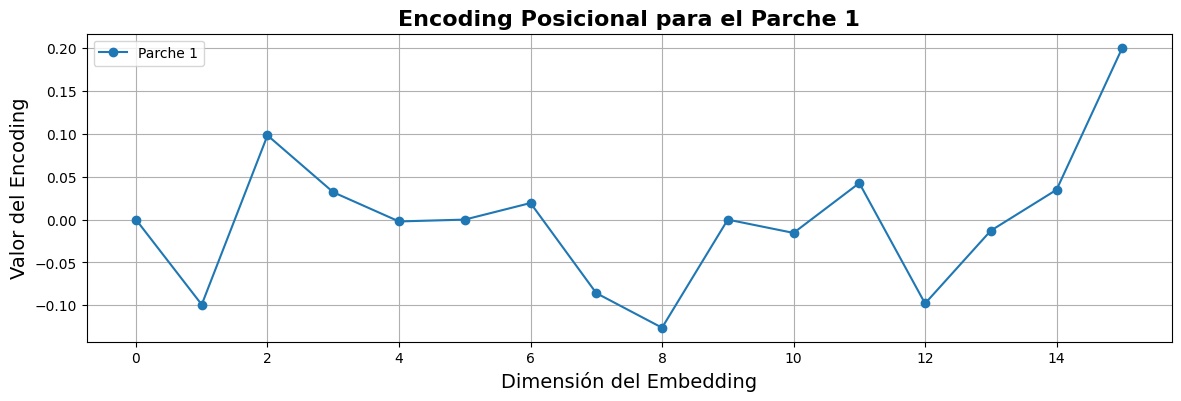


Tiempo total (Sinusoidal): 2.1283s
Tiempo total (Aprendido): 2.2952s
Diferencia: 0.1670s


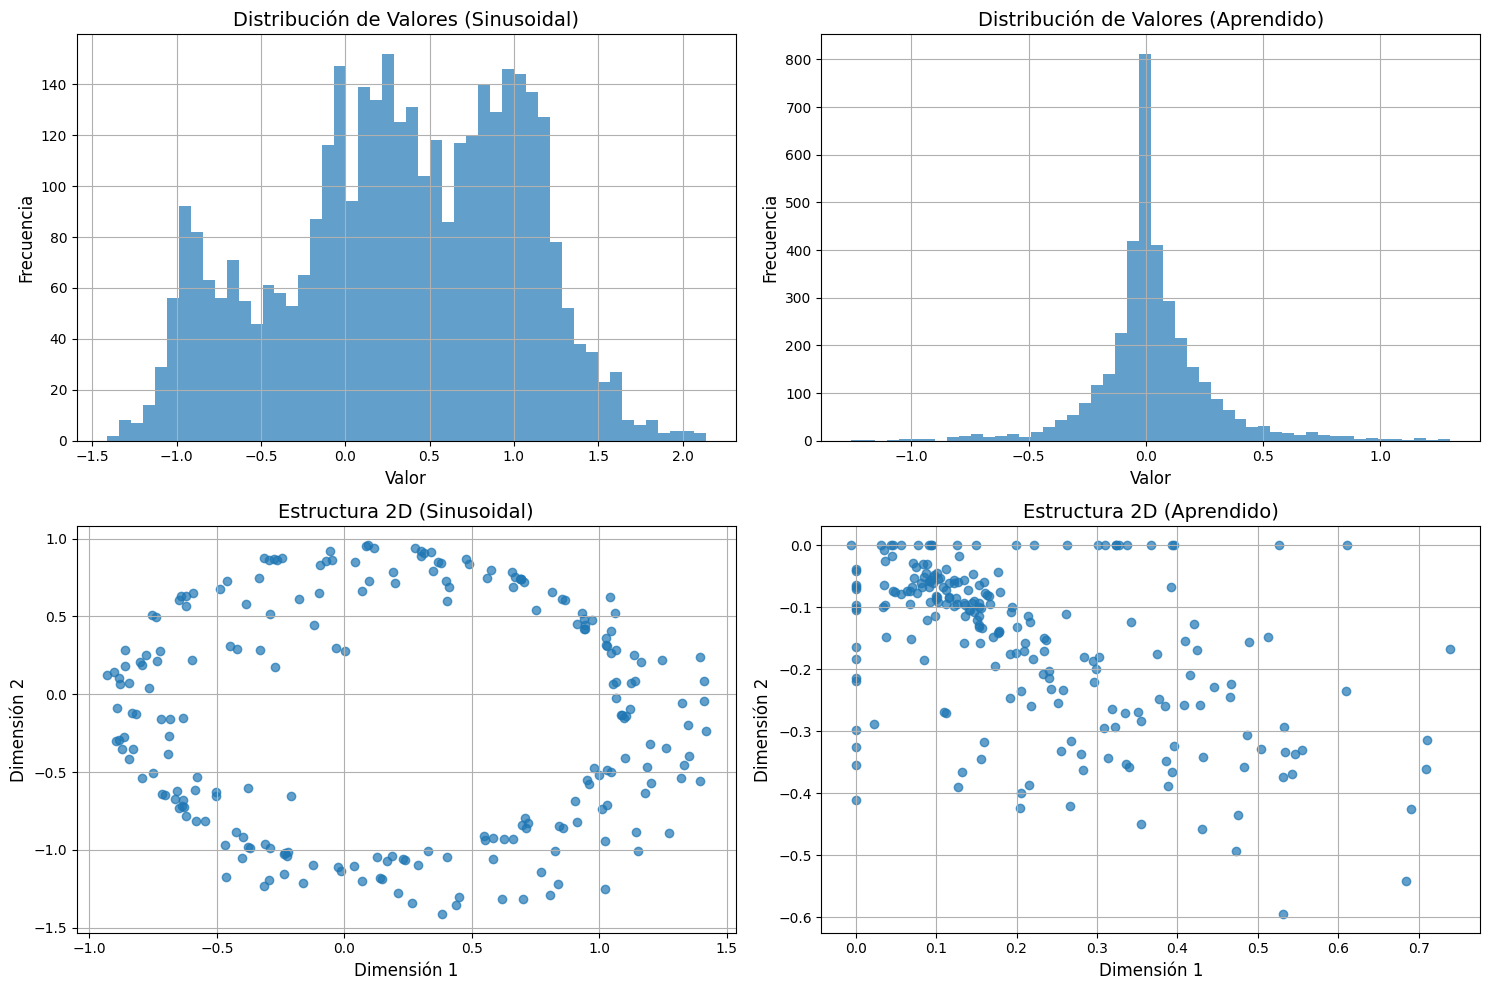


Análisis de encodings guardado en 'analisis_encodings.png'


In [7]:
probar_tipos_encoding()